In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import os
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class ToolClassifierCNN(nn.Module):
    """
    A simple but effective CNN for tool classification

    Architecture explanation:
    - 3 Convolutional blocks: Extract hierarchical features
    - Each block: Conv2d → BatchNorm → ReLU → MaxPool
    - Fully connected layers: Make final classification decision
    - Dropout: Prevent overfitting
    """

    def __init__(self, num_classes=10):
        super(ToolClassifierCNN, self).__init__()

        # Feature extraction layers (Convolutional blocks)
        self.features = nn.Sequential(
            # Block 1: Learn basic edges and patterns
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 32x16x16

            # Block 2: Learn more complex shapes
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 64x8x8

            # Block 3: Learn object-specific features
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 128x4x4
        )

        # Classification layers (Fully connected)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """Forward pass through the network"""
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.classifier(x)
        return x

In [15]:
class ToolClassificationSystem:
    """
    Complete system for tool classification with training, evaluation, and prediction
    """

    def __init__(self, data_subset_ratio=0.1, batch_size=32):
        """
        Initialize the classification system

        Args:
            data_subset_ratio: Proportion of dataset to use (0.1 = 10% for faster training)
            batch_size: Number of samples per batch
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.data_subset_ratio = data_subset_ratio
        self.batch_size = batch_size

        # CINIC-10 class names (can be adapted to your 10 tool categories)
        self.class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                           'dog', 'frog', 'horse', 'ship', 'truck']

        print(f"Using device: {self.device}")
        print(f"Using {data_subset_ratio*100}% of the dataset for faster training")

    def prepare_data(self, dataset_path):
        """
        Prepare dataset with appropriate transforms

        Data augmentation helps the model generalize better by creating variations
        of training images (rotation, flipping, etc.)
        """

        # Data transformations
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
            transforms.RandomRotation(10),            # Augmentation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        print("Loading dataset...")

        # dataset_path = kagglehub.dataset_download("mengcius/cinic10")
        train_dataset = torchvision.datasets.ImageFolder(
            os.path.join(dataset_path, 'train'), transform=train_transform
        )

        test_dataset = torchvision.datasets.ImageFolder(
            os.path.join(dataset_path, 'test'), transform=test_transform
        )
        valid_dataset = torchvision.datasets.ImageFolder(
            os.path.join(dataset_path, 'valid'), transform=test_transform # Using test transform for validation
        )

        # Create subsets for faster training
        if self.data_subset_ratio < 1.0:
            train_size = int(len(train_dataset) * self.data_subset_ratio)
            test_size = int(len(test_dataset) * self.data_subset_ratio)
            valid_size = int(len(valid_dataset) * self.data_subset_ratio)


            train_indices = torch.randperm(len(train_dataset))[:train_size]
            test_indices = torch.randperm(len(test_dataset))[:test_size]
            valid_indices = torch.randperm(len(valid_dataset))[:valid_size]

            train_dataset = Subset(train_dataset, train_indices)
            test_dataset = Subset(test_dataset, test_indices)
            valid_dataset = Subset(valid_dataset, valid_indices)

        print(f"Training samples: {len(train_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        print(f"Validation samples: {len(valid_dataset)}")


        # Create data loaders
        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2
        )

        self.test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )
        self.valid_loader = DataLoader(
            valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )

    def create_model(self):
        """Create and initialize the CNN model"""
        self.model = ToolClassifierCNN(num_classes=10).to(self.device)

        # Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-4)

        # Learning rate scheduler for better convergence
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=7, gamma=0.1)

        print(f"Model created with {sum(p.numel() for p in self.model.parameters())} parameters")

    def train_model(self, epochs=15):
        """
        Train the CNN model

        Args:
            epochs: Number of training epochs
        """
        print(f"\nStarting training for {epochs} epochs...")

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []


        for epoch in range(epochs):
            # Training
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Progress bar for training
            pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()

                # Statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.3f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })

            # Record epoch training statistics
            epoch_train_loss = running_loss / len(self.train_loader)
            epoch_train_acc = 100. * correct / total

            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_acc)

            # Validation
            self.model.eval()
            valid_loss = 0.0
            valid_correct = 0
            valid_total = 0
            with torch.no_grad():
                vbar = tqdm(self.valid_loader, desc=f'Epoch {epoch+1}/{epochs} [Valid]')
                for inputs, targets in vbar:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)

                    valid_loss += loss.item()
                    _, predicted = outputs.max(1)
                    valid_total += targets.size(0)
                    valid_correct += predicted.eq(targets).sum().item()

                    vbar.set_postfix({
                        'Loss': f'{valid_loss/(vbar.n+1):.3f}',
                        'Acc': f'{100.*valid_correct/valid_total:.2f}%'
                    })


            epoch_valid_loss = valid_loss / len(self.valid_loader)
            epoch_valid_acc = 100. * valid_correct / valid_total

            val_losses.append(epoch_valid_loss)
            val_accuracies.append(epoch_valid_acc)

            print(f'Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.2f}%, Valid Loss={epoch_valid_loss:.4f}, Valid Acc={epoch_valid_acc:.2f}%')


            # Update learning rate
            self.scheduler.step()

        # Plot training progress
        self.plot_training_progress(train_losses, train_accuracies, val_losses, val_accuracies)


        print("Training completed!")

    def evaluate_model(self):
        """
        Evaluate the trained model on test data
        Returns accuracy and detailed classification report
        """
        print("\nEvaluating model...")

        self.model.eval()
        correct = 0
        total = 0
        all_predicted = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in tqdm(self.test_loader, desc='Evaluating'):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)

                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_predicted.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        accuracy = 100. * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')

        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predicted,
                                  target_names=self.class_names, digits=3))

        # Confusion matrix
        self.plot_confusion_matrix(all_targets, all_predicted)

        return accuracy, all_targets, all_predicted

    def plot_training_progress(self, train_losses, train_accuracies, val_losses, val_accuracies):
        """Plot training and validation loss and accuracy curves"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Valid Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot
        ax2.plot(train_accuracies, label='Train Accuracy')
        ax2.plot(val_accuracies, label='Valid Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_validation_progress.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

    def predict_single_image(self, image_tensor):
        """
        Predict class for a single image

        Args:
            image_tensor: Preprocessed image tensor

        Returns:
            predicted_class, confidence_scores
        """
        self.model.eval()
        with torch.no_grad():
            image_tensor = image_tensor.unsqueeze(0).to(self.device)
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

            return predicted.item(), probabilities.cpu().numpy()[0]

    def save_model(self, filepath='tool_classifier_model.pth'):
        """Save the trained model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'class_names': self.class_names,
        }, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath='tool_classifier_model.pth'):
        """Load a pre-trained model"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.class_names = checkpoint['class_names']
        print(f"Model loaded from {filepath}")

In [17]:
# Example usage and demonstration
def main():
    """
    Main function to demonstrate the complete tool classification system
    """
    print("=== Tool Classification System Demo ===")
    dataset_path = '/content/drive/MyDrive/DL/cinic-10'

    # Initialize the system with any proportion of data for faster training (1.0 for full data)
    classifier = ToolClassificationSystem(data_subset_ratio=0.3, batch_size=64)

    # Prepare data
    classifier.prepare_data(dataset_path)

    # Create model
    classifier.create_model()

    # Train the model
    classifier.train_model(epochs=25)  # Reduced epochs for demo

    # Evaluate the model
    accuracy, y_true, y_pred = classifier.evaluate_model()

    # Save the model
    classifier.save_model()

    print(f"\n=== Results Summary ===")
    print(f"Final Test Accuracy: {accuracy:.2f}%")



    return classifier

=== Tool Classification System Demo ===
Using device: cpu
Using 30.0% of the dataset for faster training
Loading dataset...


100%|██████████| 754M/754M [00:16<00:00, 48.4MB/s]

Extracting files...


Training samples: 27000
Test samples: 27000
Validation samples: 27000
Model created with 620810 parameters

Starting training for 25 epochs...


Epoch 1/25 [Valid]: 100%|██████████| 422/422 [00:45<00:00,  9.28it/s, Loss=1.513, Acc=42.61%]


Epoch 1: Train Loss=1.7150, Train Acc=35.71%, Valid Loss=1.5095, Valid Acc=42.61%


Epoch 2/25 [Valid]: 100%|██████████| 422/422 [00:44<00:00,  9.43it/s, Loss=1.366, Acc=49.21%]


Epoch 2: Train Loss=1.4976, Train Acc=44.21%, Valid Loss=1.3629, Valid Acc=49.21%


Epoch 3/25 [Valid]: 100%|██████████| 422/422 [00:45<00:00,  9.20it/s, Loss=1.325, Acc=51.10%]


Epoch 3: Train Loss=1.3979, Train Acc=48.29%, Valid Loss=1.3216, Valid Acc=51.10%


Epoch 4/25 [Valid]: 100%|██████████| 422/422 [00:51<00:00,  8.23it/s, Loss=1.242, Acc=54.33%]


Epoch 4: Train Loss=1.3511, Train Acc=50.20%, Valid Loss=1.2425, Valid Acc=54.33%


Epoch 5/25 [Valid]: 100%|██████████| 422/422 [00:52<00:00,  8.05it/s, Loss=1.231, Acc=55.83%]


Epoch 5: Train Loss=1.2976, Train Acc=52.22%, Valid Loss=1.2285, Valid Acc=55.83%


Epoch 6/25 [Valid]: 100%|██████████| 422/422 [00:53<00:00,  7.89it/s, Loss=1.206, Acc=56.18%]


Epoch 6: Train Loss=1.2598, Train Acc=54.08%, Valid Loss=1.2062, Valid Acc=56.18%


Epoch 7/25 [Valid]: 100%|██████████| 422/422 [00:51<00:00,  8.13it/s, Loss=1.169, Acc=57.74%]


Epoch 7: Train Loss=1.2237, Train Acc=55.51%, Valid Loss=1.1692, Valid Acc=57.74%


Epoch 8/25 [Valid]: 100%|██████████| 422/422 [00:53<00:00,  7.93it/s, Loss=1.097, Acc=60.60%]


Epoch 8: Train Loss=1.1271, Train Acc=59.05%, Valid Loss=1.0942, Valid Acc=60.60%


Epoch 9/25 [Valid]: 100%|██████████| 422/422 [00:51<00:00,  8.25it/s, Loss=1.084, Acc=60.78%]


Epoch 9: Train Loss=1.1097, Train Acc=59.74%, Valid Loss=1.0838, Valid Acc=60.78%


Epoch 10/25 [Valid]: 100%|██████████| 422/422 [00:50<00:00,  8.41it/s, Loss=1.075, Acc=61.09%]


Epoch 10: Train Loss=1.0889, Train Acc=60.30%, Valid Loss=1.0753, Valid Acc=61.09%


Epoch 11/25 [Valid]: 100%|██████████| 422/422 [00:49<00:00,  8.46it/s, Loss=1.065, Acc=61.66%]


Epoch 11: Train Loss=1.0845, Train Acc=60.54%, Valid Loss=1.0651, Valid Acc=61.66%


Epoch 12/25 [Valid]: 100%|██████████| 422/422 [00:54<00:00,  7.71it/s, Loss=1.062, Acc=61.84%]


Epoch 12: Train Loss=1.0780, Train Acc=60.74%, Valid Loss=1.0615, Valid Acc=61.84%


Epoch 13/25 [Valid]: 100%|██████████| 422/422 [00:52<00:00,  8.10it/s, Loss=1.056, Acc=61.97%]


Epoch 13: Train Loss=1.0692, Train Acc=61.07%, Valid Loss=1.0534, Valid Acc=61.97%


Epoch 14/25 [Valid]: 100%|██████████| 422/422 [00:53<00:00,  7.91it/s, Loss=1.051, Acc=62.14%]


Epoch 14: Train Loss=1.0643, Train Acc=61.46%, Valid Loss=1.0507, Valid Acc=62.14%


Epoch 15/25 [Valid]: 100%|██████████| 422/422 [00:49<00:00,  8.54it/s, Loss=1.047, Acc=62.44%]


Epoch 15: Train Loss=1.0495, Train Acc=61.93%, Valid Loss=1.0465, Valid Acc=62.44%


Epoch 16/25 [Valid]: 100%|██████████| 422/422 [00:52<00:00,  8.07it/s, Loss=1.045, Acc=62.46%]


Epoch 16: Train Loss=1.0447, Train Acc=61.84%, Valid Loss=1.0447, Valid Acc=62.46%


Epoch 17/25 [Valid]: 100%|██████████| 422/422 [00:51<00:00,  8.23it/s, Loss=1.044, Acc=62.59%]


Epoch 17: Train Loss=1.0428, Train Acc=62.07%, Valid Loss=1.0436, Valid Acc=62.59%


Epoch 18/25 [Valid]: 100%|██████████| 422/422 [00:49<00:00,  8.57it/s, Loss=1.044, Acc=62.45%]


Epoch 18: Train Loss=1.0452, Train Acc=61.89%, Valid Loss=1.0443, Valid Acc=62.45%


Epoch 19/25 [Valid]: 100%|██████████| 422/422 [00:49<00:00,  8.56it/s, Loss=1.045, Acc=62.56%]


Epoch 19: Train Loss=1.0389, Train Acc=62.31%, Valid Loss=1.0447, Valid Acc=62.56%


Epoch 20/25 [Valid]: 100%|██████████| 422/422 [00:49<00:00,  8.48it/s, Loss=1.042, Acc=62.62%]


Epoch 20: Train Loss=1.0447, Train Acc=62.16%, Valid Loss=1.0423, Valid Acc=62.62%


Epoch 21/25 [Valid]: 100%|██████████| 422/422 [00:52<00:00,  8.07it/s, Loss=1.044, Acc=62.72%]


Epoch 21: Train Loss=1.0374, Train Acc=62.30%, Valid Loss=1.0415, Valid Acc=62.72%


Epoch 22/25 [Valid]: 100%|██████████| 422/422 [00:47<00:00,  8.84it/s, Loss=1.045, Acc=62.59%]


Epoch 22: Train Loss=1.0433, Train Acc=62.25%, Valid Loss=1.0425, Valid Acc=62.59%


Epoch 23/25 [Valid]: 100%|██████████| 422/422 [00:51<00:00,  8.21it/s, Loss=1.042, Acc=62.61%]


Epoch 23: Train Loss=1.0364, Train Acc=62.57%, Valid Loss=1.0419, Valid Acc=62.61%


Epoch 24/25 [Valid]: 100%|██████████| 422/422 [00:55<00:00,  7.61it/s, Loss=1.045, Acc=62.63%]


Epoch 24: Train Loss=1.0437, Train Acc=61.95%, Valid Loss=1.0422, Valid Acc=62.63%


Epoch 25/25 [Valid]: 100%|██████████| 422/422 [00:49<00:00,  8.45it/s, Loss=1.044, Acc=62.65%]


Epoch 25: Train Loss=1.0340, Train Acc=62.24%, Valid Loss=1.0411, Valid Acc=62.65%


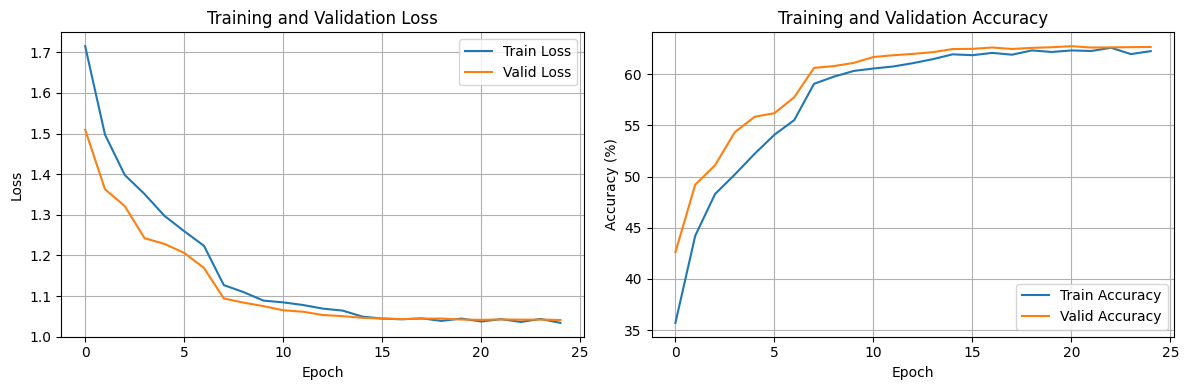

Training completed!

Evaluating model...


Evaluating: 100%|██████████| 422/422 [01:03<00:00,  6.68it/s]


Test Accuracy: 62.93%

Classification Report:
              precision    recall  f1-score   support

    airplane      0.744     0.736     0.740      2710
  automobile      0.699     0.687     0.693      2653
        bird      0.577     0.559     0.568      2703
         cat      0.469     0.468     0.469      2741
        deer      0.538     0.535     0.536      2720
         dog      0.483     0.444     0.463      2728
        frog      0.717     0.773     0.744      2676
       horse      0.676     0.694     0.685      2711
        ship      0.697     0.728     0.712      2624
       truck      0.678     0.677     0.678      2734

    accuracy                          0.629     27000
   macro avg      0.628     0.630     0.629     27000
weighted avg      0.627     0.629     0.628     27000



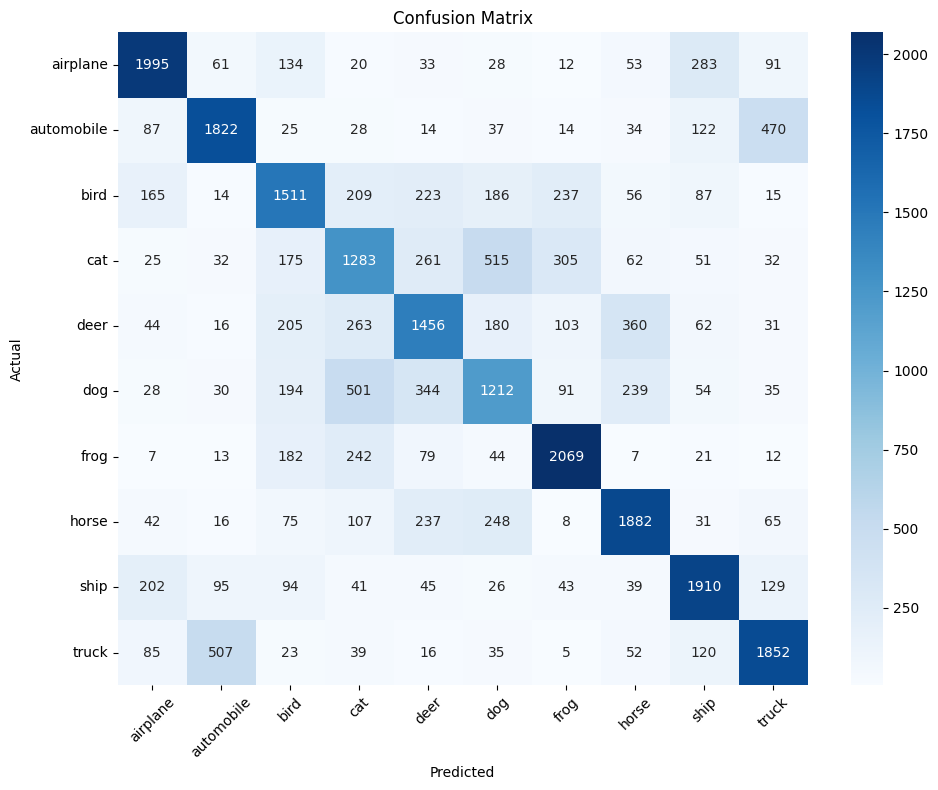

Model saved to tool_classifier_model.pth

=== Results Summary ===
Final Test Accuracy: 62.93%
⚠️  Model didn't reach 70% accuracy. Consider:
   - Training longer (more epochs)
   - Using more data (increase data_subset_ratio)
   - Tuning hyperparameters


In [18]:
if __name__ == "__main__":
    # Run the demonstration
    classifier = main()